In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rn2021q1itba-cifar100/submission_example.csv
/kaggle/input/rn2021q1itba-cifar100/y_train.npy
/kaggle/input/rn2021q1itba-cifar100/x_test.npy
/kaggle/input/rn2021q1itba-cifar100/x_train.npy


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [3]:
# parameters for data
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

In [6]:
#(X, y), (X_test, y_test) = cifar100.load_data()
X = np.load("/kaggle/input/rn2021q1itba-cifar100/x_train.npy")
X_test = np.load("/kaggle/input/rn2021q1itba-cifar100/x_test.npy")
y = np.load("/kaggle/input/rn2021q1itba-cifar100/y_train.npy")

#Dividimos entre train y validación
from sklearn.model_selection import train_test_split

# X = X / 255
# X_test = X_test / 255

X_train, X_val, y_train, y_val = train_test_split(
     X, y, test_size=0.20, random_state=42, stratify=y)

In [9]:
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [10]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, images , labels = None, mode = 'fit', batch_size = batch_size,
                 dim = (height, width), channels = channels, n_classes = n_classes,
                 shuffle = True, augment = False):
        self.images = images
        self.labels = labels
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.channels = channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augment = augment
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.images.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))
        
    def __getitem__(self, index):
        'Generate one batch of data'
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # =========================================================== #
        # Generate mini-batch of X
        # =========================================================== #
        X = np.empty((self.batch_size, *self.dim, self.channels))
        for i, ID in enumerate(batch_indexes):
            # Generate a preprocessed image
            img = self.images[ID]
            img = img.astype(np.float32) / 255.
            img = np_resize(img, self.dim)
            X[i] = img
            
        
        # =========================================================== #
        # Generate mini-batch of y
        # =========================================================== #
        if self.mode == 'fit':
            y = self.labels[batch_indexes]
            y = to_categorical(y, n_classes)
            '''
            y = np.zeros((self.batch_size, self.n_classes), dtype = np.uint8)
            for i, ID in enumerate(batch_indexes):
                # one hot encoded label
                y[i, self.labels[ID]] = 1
            '''
            # Augmentation should only be implemented in the training part.
            if self.augment == True:
                X = self.__augment_batch(X)                
            
            return X,y
        
        elif self.mode == 'predict':
            return X       
        
        else:
            raise AttributeError('The mode parameters should be set to "fit" or "predict"')
            
    def __random_transform(self, img):
        composition = albu.Compose([albu.HorizontalFlip(p = 0.5),
                                    albu.VerticalFlip(p = 0.5),
                                    albu.GridDistortion(p = 0.2),
                                    albu.ElasticTransform(p = 0.2)])
        
        return composition(image = img)['image']
        
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i] = self.__random_transform(img_batch[i])
            
        return img_batch

In [11]:
train_generator = DataGenerator(X_train, y_train, augment = True)
valid_generator = DataGenerator(X_val, y_val, augment = False)

In [12]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 520 kB/s eta 0:00:01


In [13]:
import efficientnet.keras as efn 

efnb0 = efn.EfficientNetB0(weights = 'imagenet', include_top = False, classes = n_classes, input_shape = input_shape)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation = 'softmax'))

model.summary()

16809984/16804768 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [14]:
sgd = SGD(lr = lr, momentum = 0.9, nesterov = True)
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = es_patience, restore_best_weights = True, verbose = 1)
rlrop = ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', patience = rlrop_patience, 
                        factor = decay_rate, min_lr = 1e-6, verbose = 1)

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['acc'])

In [19]:
hist = model.fit(train_generator,validation_data = valid_generator, 
                           epochs = epochs, verbose = 1, callbacks = [es, rlrop],  steps_per_epoch=len(train_generator))

model.save_weights("best_weight.h5")

Epoch 1/25
625/625 [==============================] - 93s 149ms/step - loss: 1.3492 - acc: 0.6258 - val_loss: 0.9728 - val_acc: 0.7212
Epoch 2/25
625/625 [==============================] - 91s 145ms/step - loss: 1.3624 - acc: 0.6222 - val_loss: 1.0685 - val_acc: 0.6919
Epoch 3/25
625/625 [==============================] - 95s 151ms/step - loss: 1.3454 - acc: 0.6204 - val_loss: 0.9392 - val_acc: 0.7209
Epoch 4/25
625/625 [==============================] - 95s 151ms/step - loss: 1.3234 - acc: 0.6334 - val_loss: 0.8854 - val_acc: 0.7354
Epoch 5/25
625/625 [==============================] - 95s 151ms/step - loss: 1.2998 - acc: 0.6370 - val_loss: 0.8870 - val_acc: 0.7357
Epoch 6/25
625/625 [==============================] - 95s 151ms/step - loss: 1.2952 - acc: 0.6368 - val_loss: 0.8278 - val_acc: 0.7528
Epoch 7/25
625/625 [==============================] - 95s 152ms/step - loss: 1.2885 - acc: 0.6398 - val_loss: 0.9053 - val_acc: 0.7288
Epoch 8/25
625/625 [==============================] - 9

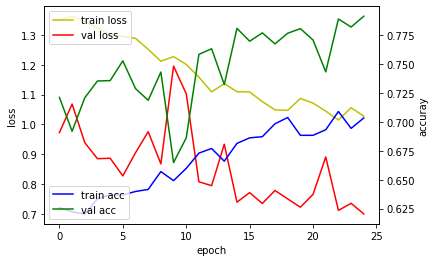

In [20]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [21]:
y_test = model.predict(X_test).argmax(axis=-1)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer sequential: expected shape=(None, 224, 224, 3), found shape=(None, 32, 32, 3)


In [ ]:
y_test

In [ ]:
#Salvo las predicciones y genero el archivo csv según el formato pedido
df = pd.DataFrame(y_test, columns=["label"])
df.index.name = "Id"
df.to_csv("submission.csv")

In [ ]:
# model.load_weights("../input/%s/best_weight.h5" % (os.listdir('../input')[0]))
print("The Accuracy on the validation data : {:.2f}%".format(100 * model.evaluate_generator(valid_generator, verbose = 1)[-1]))

In [22]:
# Make sure to set shuffle be False.
test_generator = DataGenerator(X_test, mode = 'predict', augment = False, shuffle = False)
y_pred = model.predict_generator(test_generator,verbose = 1)
y_pred = np.argmax(y_pred, axis = 1)

print("The accuracy on the testing data : {:.2f}%".format(100 * accuracy_score(y_test, y_pred)))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1250/1250 [==============================] - 18s 13ms/step


NameError: name 'y_test' is not defined

In [23]:
y_pred

array([68, 33, 55, ..., 51, 42, 70])

In [25]:
#Salvo las predicciones y genero el archivo csv según el formato pedido
df = pd.DataFrame(y_pred, columns=["label"])
df.index.name = "Id"
df.to_csv("submission2.csv")